In [2]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Setup
#headers = {
#    'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.162 Safari/537.36'
#}
#base_url = 'https://www.quikr.com/homes/property/residential-for-sale-in-pune-cid_33?page={}'

# List to store all listings
#records = []

# Loop through 5 pages
#for page in range(1, 5001):
#    url = base_url.format(page)
#    response = requests.get(url, headers=headers)
#    soup = BeautifulSoup(response.text, 'html.parser')

    # Extract property summary and detail blocks
#    properties = soup.find_all('div', class_='tophe')
#    details = soup.find_all('ul', class_='project_d clearfix')

    # Ensure matching length
#    min_len = min(len(properties), len(details))

#    for prop, block in zip(properties[:min_len], details[:min_len]):
        # Title
#        title_tag = prop.find('a', class_='listtitle notclickb', rel='noopener', target='_blank')
#        title = title_tag.get_text(strip=True) if title_tag else None

        # Price
#        price_tag = prop.find('div', class_='liprice')
#        price = price_tag.get_text(strip=True) if price_tag else None

        # Detail fields
#        transaction, area, availability = None, None, None
#        for li in block.find_all('li'):
#            label = li.get_text(separator='|', strip=True)
#            if 'Transaction' in label:
#                span = li.find('span')
#                transaction = span.get_text(strip=True) if span else None
#            elif 'Built-Up Area' in label:
#                span = li.find('span')
#                area = span.get_text(strip=True) if span else None
#            elif 'Availability' in label:
#                span = li.find('span')
#                availability = span.get_text(strip=True) if span else None

#        records.append({
#            'Title': title,
#            'Price': price,
#            'Transaction': transaction,
#            'Built-Up Area': area,
#            'Availability': availability
#        })

#    print(f"Scraped page {page}")
#    time.sleep(1)  # polite delay

# Convert to DataFrame
#df_1 = pd.DataFrame(records)

# Show result


# Optional: Save to CSV
# df.to_csv("quikr_pune_properties_20250726.csv", index=False)


In [4]:
#df_1.to_csv("quikr_pune_properties_20250726.csv", index=False)

In [5]:
df_1 = pd.read_csv("quikr_pune_properties_20250726.csv")

In [6]:
df = df_1.copy()

In [7]:
df.drop_duplicates(inplace = True)
df.rename(columns = {'Built-Up Area':'Area'},inplace = True)

In [8]:
# Extracting exact location from Pune city.

def extract_location(title):
    match = re.search(r'in\s+(.*)', title, re.IGNORECASE)
    return match.group(1).strip() if match else None

# Create new 'Location' column
df['Location'] = df['Title'].apply(extract_location)

# Optional: move Location next to Title
cols = df.columns.tolist()
cols.insert(cols.index('Title') + 1, cols.pop(cols.index('Location')))
df = df[cols]

In [9]:
#### pre-processing on location column

def location(location):
    if pd.isnull(location):
        return location  # Keep None/NaN as-is

    replace_items = [', Pune', ' Main Road', 'Pune, ', '.']
    for item in replace_items:
        location = location.replace(item, '')
    return location

df['Location'] = df['Location'].apply(location)

In [10]:
#### pre-processing on location column

location_map = {
    'Chinchwad': 'Pimpri Chinchwad',
    'Pimpri': 'Pimpri Chinchwad',
    'Wakad': 'Wakad',
    'Hinjawadi': 'Hinjewadi',
    'Hinjewadi': 'Hinjewadi',
    'Tathawade': 'Tathawade',
    'Ravet': 'Ravet',
    'Kharadi': 'Kharadi',
    'Baner': 'Baner',
    'Hadapsar': 'Hadapsar',
    'Sinhagad': 'Sinhagad Road',
    'Sinhgad': 'Sinhagad Road',
    'Nigdi': 'Nigdi'
}

def location(location):
    if pd.isnull(location):
        return location  # Return as-is if null
    
    location_str = str(location)
    for keyword, standard in location_map.items():
        if keyword in location_str:
            return standard
    return location_str

df['Location'] = df['Location'].apply(location)


In [11]:
mask = df['Area'].isna()
pattern = r'(\d{3,5})\s*sq\s*\.?\s*ft'
df.loc[mask, 'Area'] = df.loc[mask, 'Title'].str.extract(pattern, flags=re.IGNORECASE)[0]

df['BHK'] = df['Title'].str.extract(r'(\d{1,2})\+?\s*BHK', flags=re.IGNORECASE)[0]

df = df[~df['Title'].str.contains(r'\bplot\b', case=False, na=False)]
df = df[~df['Title'].str.contains(r'\bvilla\b', case=False, na=False)]
df = df[~df['Price'].str.contains(r'\bcontact\b', case=False, na=False)]

df = df[df['Area'].notna()]
df = df[df['Location'].notna()]

In [12]:
def convert_price(value):
    text = str(value).lower().strip()

    # Handle crore/crores
    match_crore = re.search(r'([\d\.]+)\s*crore', text)
    if match_crore:
        return float(match_crore.group(1)) * 100  # Convert to lakhs

    # Handle lakh/lakhs/lac/lacs
    match_lakh = re.search(r'([\d\.]+)\s*(lakh|lakhs|lac|lacs)', text)
    if match_lakh:
        return float(match_lakh.group(1))

    # Handle pure numeric values (assume it's in lakhs already)
    match_number = re.fullmatch(r'[\d\.]+', text)
    if match_number:
        return float(text)

    return None  # If nothing matches

# Apply conversion
df['Price_in_lakh'] = df['Price'].apply(convert_price)
df['Price_in_lakh'] = df['Price_in_lakh'].astype(int)

In [13]:
def extract_sqft(area):
    if pd.isna(area):
        return None

    area = str(area).lower()

    # If sqft is present, extract it
    match_sqft = re.search(r'(\d+\.?\d*)\s*sq\.?ft', area)
    if match_sqft:
        return float(match_sqft.group(1))

    # If only sqm is present, convert to sqft
    match_sqm = re.search(r'(\d+\.?\d*)\s*sq\.?m', area)
    if match_sqm:
        sqm = float(match_sqm.group(1))
        return round(sqm * 10.7639, 2)

    return None

# Apply the function
df['Area_in_sqft'] = df['Area'].apply(extract_sqft)
df['Area_in_sqft'] = df['Area_in_sqft'].astype(int)

In [14]:
df.drop(['Title','Area','Price','Availability','Transaction'], axis=1,inplace = True)

In [15]:
df = df[~df['Location'].str.contains('Baramati', case=False, na=False)]
df = df[~df['Location'].str.contains('Bhor', case=False, na=False)]
df = df[~df['Location'].str.contains('society', case=False, na=False)]

In [16]:
df.isnull().sum()

Location         0
BHK              0
Price_in_lakh    0
Area_in_sqft     0
dtype: int64

In [17]:
df['price_per_sqft'] = round((df['Price_in_lakh'] * 100000) / df['Area_in_sqft'],0)
df['price_per_sqft'] = df['price_per_sqft'].astype('int')

In [18]:
df['BHK'] = df['BHK'].astype('int')

In [19]:
df.columns

Index(['Location', 'BHK', 'Price_in_lakh', 'Area_in_sqft', 'price_per_sqft'], dtype='object')

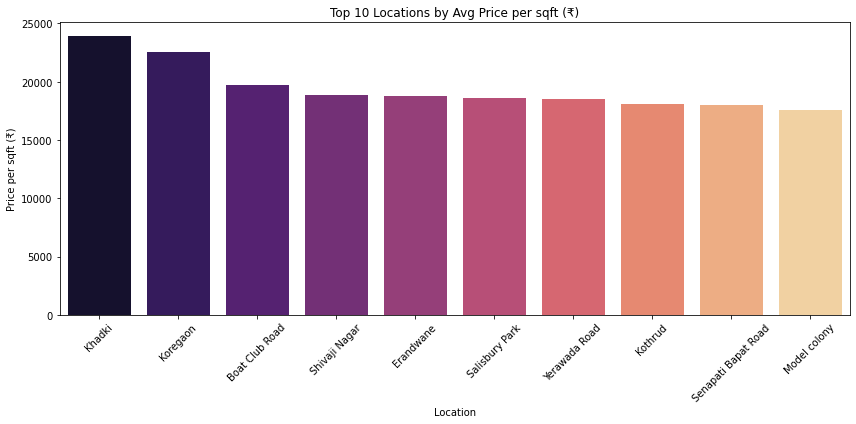

In [20]:
top10_locations = df.groupby('Location')['price_per_sqft'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
sns.barplot(x=top10_locations.index, y=top10_locations.values, palette='magma')
plt.title('Top 10 Locations by Avg Price per sqft (₹)')
plt.ylabel('Price per sqft (₹)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

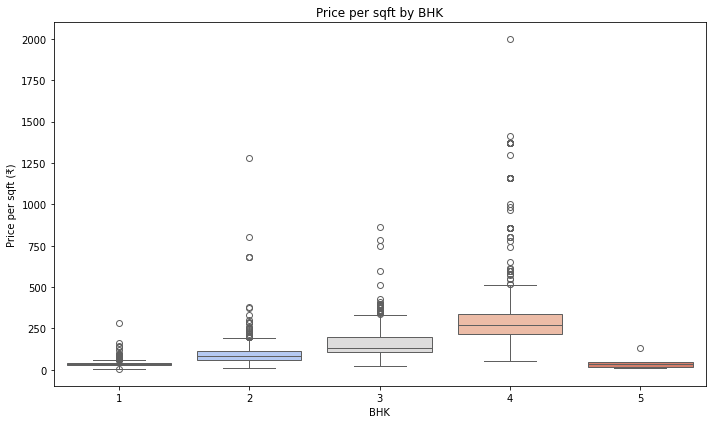

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='BHK', y='Price_in_lakh', palette='coolwarm')
plt.title('Price per sqft by BHK')
plt.ylabel('Price per sqft (₹)')
plt.xlabel('BHK')
plt.tight_layout()
plt.show()

In [22]:
dff = df.copy()
dff = dff.drop_duplicates()
dff.shape

(9830, 5)

In [23]:
dff

,Location,BHK,Price_in_lakh,Area_in_sqft,price_per_sqft
0,Tathawade,2,65,643,10109
1,Tathawade,2,82,743,11036
2,Kharadi,5,47,270,17407
3,Ravet,3,204,1850,11027
4,Sahakar Nagar,3,195,1351,14434
...,...,...,...,...,...
15982,Moshi,2,44,861,5110
15983,Moshi,1,38,594,6397
15984,Wakad,2,57,813,7011
15985,Narhe,2,58,1175,4936


Outlier detection & outlier removal using Z-SCORE scaling

In [24]:
dff['expected_area'] = dff['BHK'] * 300
dff['area_deviation'] = dff['Area_in_sqft'] - dff['expected_area']

# Keep only rows with area_deviation >= 0
dff = dff[(dff['area_deviation'] >= 0) & (dff['area_deviation'] <= 1000)]
dff.shape

(9378, 7)

In [25]:
######## finding z-score to detect outliers using scipy library

from scipy.stats import zscore

In [26]:
dff['z_score'] = zscore(dff['price_per_sqft'])
dff = dff[dff['z_score'].abs() <= 3]
dff.shape

(9340, 8)

In [27]:
dff['price_per_sqft_log'] = np.log1p(dff['price_per_sqft'])  # log1p = log(1 + x)
dff['Price_in_lakh_log'] = np.log1p(dff['Price_in_lakh'])
dff['Area_in_sqft_log'] = np.log1p(dff['Area_in_sqft'])

In [28]:
dff

,Location,BHK,Price_in_lakh,Area_in_sqft,price_per_sqft,expected_area,area_deviation,z_score,price_per_sqft_log,Price_in_lakh_log,Area_in_sqft_log
0,Tathawade,2,65,643,10109,600,43,-0.136620,9.221280,4.189655,6.467699
1,Tathawade,2,82,743,11036,600,143,0.070235,9.309009,4.418841,6.612041
3,Ravet,3,204,1850,11027,900,950,0.068227,9.308193,5.323010,7.523481
4,Sahakar Nagar,3,195,1351,14434,900,451,0.828481,9.577411,5.278115,7.209340
5,Katraj,2,71,1071,6629,600,471,-0.913163,8.799360,4.276666,6.977281
...,...,...,...,...,...,...,...,...,...,...,...
15982,Moshi,2,44,861,5110,600,261,-1.252120,8.539150,3.806662,6.759255
15983,Moshi,1,38,594,6397,300,294,-0.964933,8.763741,3.663562,6.388561
15984,Wakad,2,57,813,7011,600,213,-0.827922,8.855378,4.060443,6.701960
15985,Narhe,2,58,1175,4936,600,575,-1.290947,8.504513,4.077537,7.069874


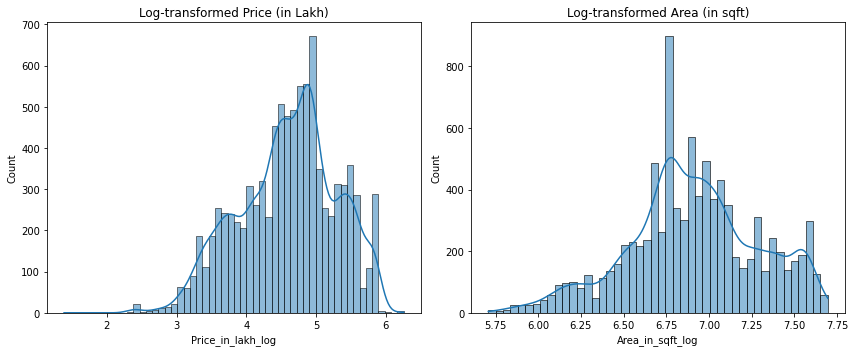

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(dff['Price_in_lakh_log'], kde=True, ax=axes[0])
axes[0].set_title('Log-transformed Price (in Lakh)')

sns.histplot(dff['Area_in_sqft_log'], kde=True, ax=axes[1])
axes[1].set_title('Log-transformed Area (in sqft)')

plt.tight_layout()
plt.show()

In [30]:
print("Skewness of Area_in_sqft (before log):", dff['Area_in_sqft'].skew())
print("Skewness of Area_in_sqft_log (after log):", dff['Area_in_sqft_log'].skew())

Skewness of Area_in_sqft (before log): 0.7187557732755846
Skewness of Area_in_sqft_log (after log): -0.1804508939136122


In [31]:
dff = dff.drop(columns = ['expected_area','area_deviation','z_score','Price_in_lakh','Area_in_sqft','price_per_sqft'])

In [32]:
dff.rename(columns={
    'price_per_sqft_log': 'Price_per_sqft_log',
    'Price_in_lakh_log': 'log_price'
}, inplace=True)

In [33]:
dff

,Location,BHK,Price_per_sqft_log,log_price,Area_in_sqft_log
0,Tathawade,2,9.221280,4.189655,6.467699
1,Tathawade,2,9.309009,4.418841,6.612041
3,Ravet,3,9.308193,5.323010,7.523481
4,Sahakar Nagar,3,9.577411,5.278115,7.209340
5,Katraj,2,8.799360,4.276666,6.977281
...,...,...,...,...,...
15982,Moshi,2,8.539150,3.806662,6.759255
15983,Moshi,1,8.763741,3.663562,6.388561
15984,Wakad,2,8.855378,4.060443,6.701960
15985,Narhe,2,8.504513,4.077537,7.069874


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

I want apply one hot encoding on location col

In [45]:
# Normalize location capitalization before grouping
dff['Location'] = dff['Location'].str.strip().str.title()

# Group rare locations
location_counts = dff['Location'].value_counts()
rare_locations = location_counts[location_counts <= 20].index
dff['Location'] = dff['Location'].apply(lambda x: 'Others' if x in rare_locations else x)

model_features = dff.drop(columns=['log_price']).columns.tolist()

joblib.dump(model_features, r'C:\Users\rohit\Desktop\Machine Learning\housing_app\model_features.pkl')

['C:\\Users\\rohit\\Desktop\\Machine Learning\\housing_app\\model_features.pkl']

In [46]:
# Define features and target
X = dff[['Location', 'BHK', 'Area_in_sqft_log']]
y = dff['log_price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Preprocessing
categorical_features = ['Location']
numeric_features = ['BHK', 'Area_in_sqft_log']

preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('scale', StandardScaler(), numeric_features)
])

# USING LINEAR REGRESSION FOR THE PREDICTION

In [48]:
# Full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Location']),
                                                 ('scale', StandardScaler(),
                                                  ['BHK',
                                                   'Area_in_sqft_log'])])),
                ('model', LinearRegression())])

In [49]:
# Save model and rare locations
joblib.dump(pipeline, r'C:\Users\rohit\Desktop\Machine Learning\housing_app\linear_regression_model.pkl')
joblib.dump(rare_locations.tolist(), r'C:\Users\rohit\Desktop\Machine Learning\housing_app\rare_locations.pkl')

print("✅ Model and metadata saved!")

✅ Model and metadata saved!


In [50]:
import pandas as pd
import numpy as np
import joblib

def predict_price(location, bhk, area_in_sqft):
    # Load saved pipeline and rare location list
    pipeline = joblib.load('linear_regression_model.pkl')
    rare_locations = joblib.load(r'C:\Users\rohit\Desktop\Machine Learning\housing_app\rare_locations.pkl')

    # Preprocess input
    location_cleaned = location.strip().title()
    if location_cleaned in rare_locations:
        location_cleaned = 'Others'

    input_df = pd.DataFrame([{
        'Location': location_cleaned,
        'BHK': bhk,
        'Area_in_sqft_log': np.log1p(area_in_sqft)
    }])

    # Predict
    try:
        log_pred = pipeline.predict(input_df)
        price = np.expm1(log_pred)[0]
        return f"🏠 Predicted Price: ₹{round(price, 2)} Lakh"
    except Exception as e:
        return f"❌ Error: {e}"

# ✅ Example usage
print(predict_price("Wakad", 2, 850))


🏠 Predicted Price: ₹85.0 Lakh


# USING RANDOM FOREST FOR THE PREDICTION

In [51]:
# Full pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])


In [52]:
# Train model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Location']),
                                                 ('scale', StandardScaler(),
                                                  ['BHK',
                                                   'Area_in_sqft_log'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [53]:
# Save model and location info
joblib.dump(pipeline, r'C:\Users\rohit\Desktop\Machine Learning\housing_app\rf_model.pkl')
joblib.dump(rare_locations.tolist(), 'rare_locations.pkl')

print("✅ Random Forest model saved as rf_model.pkl")

✅ Random Forest model saved as rf_model.pkl


In [54]:
def predict_rf_price(location, bhk, area_in_sqft):
    pipeline = joblib.load('rf_model.pkl')
    rare_locations = joblib.load('rare_locations.pkl')

    location_cleaned = location.strip().title()
    if location_cleaned in rare_locations:
        location_cleaned = 'Others'

    input_df = pd.DataFrame([{
        'Location': location_cleaned,
        'BHK': bhk,
        'Area_in_sqft_log': np.log1p(area_in_sqft)
    }])

    try:
        log_pred = pipeline.predict(input_df)
        price = np.expm1(log_pred)[0]
        return f"🌲 RF Predicted Price: ₹{round(price, 2)} Lakh"
    except Exception as e:
        return f"❌ Error: {e}"

# Example
print(predict_rf_price("Wakad", 2, 850))

🌲 RF Predicted Price: ₹58.55 Lakh


# USING XG BOOST FOR THE PREDICTION

In [55]:
# Pipeline with XGBoost
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(n_estimators=100, random_state=42))
])

In [56]:
pipeline.fit(X_train, y_train)

# Save model
joblib.dump(pipeline, r'C:\Users\rohit\Desktop\Machine Learning\housing_app\xgb_model.pkl')
joblib.dump(rare_locations.tolist(), 'rare_locations.pkl')

print("✅ XGBoost model saved as xgb_model.pkl")

✅ XGBoost model saved as xgb_model.pkl


In [57]:
def predict_xgb_price(location, bhk, area_in_sqft):
    pipeline = joblib.load('xgb_model.pkl')
    rare_locations = joblib.load('rare_locations.pkl')

    location_cleaned = location.strip().title()
    if location_cleaned in rare_locations:
        location_cleaned = 'Others'

    input_df = pd.DataFrame([{
        'Location': location_cleaned,
        'BHK': bhk,
        'Area_in_sqft_log': np.log1p(area_in_sqft)
    }])

    try:
        log_pred = pipeline.predict(input_df)
        price = np.expm1(log_pred)[0]
        return f"⚡ XGB Predicted Price: ₹{round(price, 2)} Lakh"
    except Exception as e:
        return f"❌ Error: {e}"

# Example
print(predict_xgb_price("Wakad", 2, 850))

⚡ XGB Predicted Price: ₹69.1500015258789 Lakh


In [59]:
import streamlit as st

In [60]:
# Load model and feature metadata
model = joblib.load(r'C:\Users\rohit\Desktop\Machine Learning\housing_app\linear_regression_model.pkl')
model_features = joblib.load(r'C:\Users\rohit\Desktop\Machine Learning\housing_app\model_features.pkl')
rare_locations = joblib.load(r'C:\Users\rohit\Desktop\Machine Learning\housing_app\rare_locations.pkl')

st.title("🏠 House Price Prediction in Pune")
st.markdown("Enter the property details below:")

# User Inputs
location_input = st.text_input("Location", "Wakad")
bhk = st.slider("Number of Bedrooms (BHK)", 1, 10, 2)
area = st.number_input("Area (in sqft)", min_value=200, max_value=10000, value=850)

# Prediction Logic
def preprocess_input(location, bhk, area_sqft):
    location_cleaned = location.strip().title()

    # Handle rare location
    if location_cleaned in rare_locations:
        location_cleaned = 'Others'

    # Create empty dataframe with all model features
    input_data = pd.DataFrame(columns=model_features)
    input_data.loc[0] = [0] * len(model_features)

    # Fill in numeric features
    input_data.at[0, 'BHK'] = bhk
    input_data.at[0, 'Area_in_sqft_log'] = np.log1p(area_sqft)

    # Fill in one-hot encoded location
    location_col = f'Location_{location_cleaned}'
    if location_col in input_data.columns:
        input_data.at[0, location_col] = 1

    return input_data

if st.button("Predict Price"):
    input_df = preprocess_input(location_input, bhk, area)
    try:
        log_pred = model.predict(input_df)
        price = np.expm1(log_pred)[0]
        st.success(f"💰 Predicted Price: ₹{price:.2f} Lakh")
    except Exception as e:
        st.error(f"❌ Prediction Error: {e}")

2025-07-28 20:58:51.652 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 20:58:52.030 
  command:

    streamlit run c:\users\rohit\appdata\local\programs\python\python38\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-28 20:58:52.031 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 20:58:52.032 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 20:58:52.036 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 20:58:52.038 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 20:58:52.039 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-28 20:58:5